# Import libraries

# Import pandas as pd


In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from keras.preprocessing.text import one_hot, Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential

from keras.layers.core import Activation, Dropout, Dense

from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

from sklearn.model_selection import train_test_split

## Loading dataset

In [3]:
pd.set_option("display.max_columns",None)

pd.set_option("display.max_rows",None)

In [4]:
Movie_Ratings = pd.read_csv("Sentiment_dataset.csv")

#  Understand Movie_Ratings Dataset In Twitter

In [5]:
Movie_Ratings.head(10)

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

# Movie_Ratings columns

In [6]:
for col in Movie_Ratings.columns:
    print(col)

review
sentiment


# Movie_Ratings shape

In [7]:
Movie_Ratings.shape

(50000, 2)

In [8]:
Movie_Ratings.info

<bound method DataFrame.info of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
5      Probably my all-time favorite movie, a story o...  positive
6      I sure would like to see a resurrection of a u...  positive
7      This show was an amazing, fresh & innovative i...  negative
8      Encouraged by the positive comments about this...  negative
9      If you like original gut wrenching laughter yo...  positive
10     Phil the Alien is one of those quirky films wh...  negative
11     I saw this movie when I was about 12 when it c...  negative
12     So im not a big fan of Boll's work but then ag...  negative
13     The cast played Shakesp

# Check IF Dataset Contain Null_Values or Not

In [9]:
Movie_Ratings.isnull().values.any()

False

In [10]:
Movie_Ratings_info = pd.DataFrame(columns=['Name Columns' , 'Null Values' , 'Dtype' , 'Unique Values'])

for i in range(0, len(Movie_Ratings.columns)):
       Movie_Ratings_info.loc[i] = [Movie_Ratings.columns[i],
                         Movie_Ratings[Movie_Ratings.columns[i]].isnull().sum(),
                         Movie_Ratings[Movie_Ratings.columns[i]].dtypes,
                         Movie_Ratings[Movie_Ratings.columns[i]].nunique()] 
Movie_Ratings_info

Name Columns  Null Values   Dtype  Unique Values
0       review            0  object          49582
1    sentiment            0  object              2

# Check IF Dataset Balanced or Not

In [11]:
Movie_Ratings.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

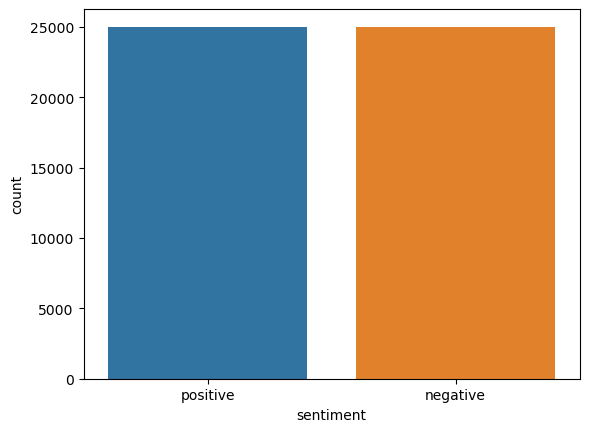

In [12]:
import seaborn as sns
sns.countplot(x='sentiment', data=Movie_Ratings)

# Preprocessing Movie_Ratings DataSet in Twitter

In [13]:
print("\033[1m\u001b[1m The First 5 Texts before Cleaning:\033[0m",*Movie_Ratings["review"][:5], sep = "\n")

 The First 5 Texts before Cleaning:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main 

In [14]:
Movie_Ratings["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [15]:
import re
Remove_Tags= re.compile(r'<[^>]+>')
def remove_tags(review):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return Remove_Tags.sub('', review)

Movie_Ratings["Clean_Text"] = Movie_Ratings["review"].apply(remove_tags)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[1m The First 20 Texts after cleaning:\033[0m",*Movie_Ratings["Clean_Text"][:20], sep = "\n")

 The First 20 Texts after cleaning:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fac

In [16]:
def preprocess_text(review):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    review = review.lower()

    # Remove punctuations and numbers
    review = re.sub('[^a-zA-Z]', ' ', review)

    # Single character removal
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ',review)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    review = re.sub(r'\s+', ' ', review)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    review = pattern.sub('', review)

    return review

In [17]:
Movie_Ratings["Clean_Text"] = Movie_Ratings["review"].apply(preprocess_text)

print("\033[1m\u001b[1m The First 20 Texts after cleaning:\033[0m",*Movie_Ratings["Clean_Text"][:20], sep = "\n")

 The First 20 Texts after cleaning:
one reviewers mentioned watching oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle clas

In [18]:
import re
import nltk

def Clean(review):
    sms = sms.split()
    sms = ' '.join(sms)
    return sms


Movie_Ratings["Tokenize_Text"]=Movie_Ratings.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[1m The First 20 Texts after Tokenizing:\033[0m",*Movie_Ratings["Tokenize_Text"][:20], sep = "\n")

 The First 20 Texts after Tokenizing:
['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty',

In [19]:
from nltk.corpus import stopwords
def remove_stopwords(review):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in review if word not in stop_words]
    return filtered_text

Movie_Ratings["Nostopword_Text"] = Movie_Ratings["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[1m The First 20 Texts after removing the stopwords:\033[0m",*Movie_Ratings["Nostopword_Text"][:20], sep = "\n")


 The First 20 Texts after removing the stopwords:
['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(review):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in review]
    return lemmas

Movie_Ratings["Lemmatized_Text"] = Movie_Ratings["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[1m The First 20 Texts after lemitization:\033[0m",*Movie_Ratings["Lemmatized_Text"][:20], sep = "\n")


 The First 20 Texts after lemitization:
['one', 'reviewers', 'mention', 'watch', 'oz', 'episode', 'hook', 'right', 'exactly', 'happen', 'br', 'br', 'first', 'thing', 'strike', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'call', 'oz', 'nickname', 'give', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffle', 'death', 'star', 'dodgy', 'deal', 'shady', 'agreements', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainst

In [21]:
Movie_Ratings.head()

review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                          Clean_Text  \
0  one reviewers mentioned watching oz episode ho...   
1  wonderful little production br br filming tech...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love time money visually stunnin...   

                                       Tokenize_Text  \
0  [one, reviewers, mentioned, watching, oz, epis...   
1  [wonderful, little, production, br, br, filmin...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, family, little, boy, jake, thinks,...   
4  [petter, mattei, love, time, money, visually, ...   

                                     Nostopword_Text  \
0  [one, reviewers, mentioned, watching, oz, epis...   
1  [wonderful, little, production, br, br, filmin...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, family, little, boy, jake, thinks,...   
4  [petter, mattei, love, time, money, visually, ...   

                                     Lemmatized_Text  
0  [one, reviewers, mention, watch, oz, episode, ...  
1  [wonderful, little, production, br, br, film, ...  
2  [think, wonderful, way, spend, time, hot, summ...  
3  [basically, family, little, boy, jake, think, ...  
4  [petter, mattei, love, time, money, visually, ...

<AxesSubplot:>

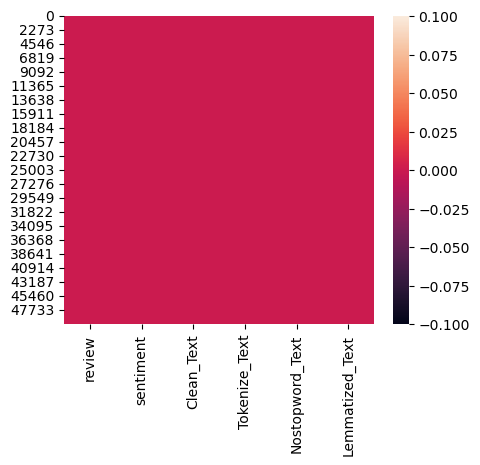

In [22]:
plt.figure(figsize=(5,4))
sns.heatmap(Movie_Ratings.isnull())

In [23]:
X= []
for i in Movie_Ratings["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    X.append(msg)
    
X[:5]
print("\033[1m\u001b[1m The First 20 lines in corpus :\033[0m",*X[:2], sep = "\n")

 The First 20 lines in corpus :
one reviewers mention watch oz episode hook right exactly happen br br first thing strike oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word br br call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffle death star dodgy deal shady agreements never far away br br would say main appeal show due fact go show dare forget pretty picture paint mainstream audiences forget charm forget romance oz mess around first episode ever saw strike nasty surreal say ready watch develop taste oz get accustom high level graphic violence violence injustice crook guard sell nickel inmates kill order get away well mannered middle class inmates turn prison bitch due lack street ski

In [65]:
# Converting sentiment labels to 0 & 1

y = Movie_Ratings['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

In [67]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [68]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

82324

In [69]:
# Padding all reviews to fixed length 100

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [70]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [71]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 200))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

ValueError: could not broadcast input array from shape (100,) into shape (200,)

In [63]:
embedding_matrix.shape

(82324, 200)

# Model Training With :

# Simple Neural_Network

In [32]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [33]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8232400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 8,242,401
Trainable params: 10,001
Non-trainable params: 8,232,400
_________________________________________________________________
None


In [34]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Epoch 1/10
317/317 [==============================] - 1s 3ms/step - loss: 0.5571 - acc: 0.7149 - val_loss: 0.5039 - val_acc: 0.7609
Epoch 2/10
317/317 [==============================] - 1s 2ms/step - loss: 0.4592 - acc: 0.7878 - val_loss: 0.4960 - val_acc: 0.7678
Epoch 3/10
317/317 [==============================] - 1s 2ms/step - loss: 0.4297 - acc: 0.8042 - val_loss: 0.5063 - val_acc: 0.7660
Epoch 4/10
317/317 [==============================] - 1s 2ms/step - loss: 0.4115 - acc: 0.8166 - val_loss: 0.5104 - val_acc: 0.7627
Epoch 5/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3979 - acc: 0.8228 - val_loss: 0.5270 - val_acc: 0.7578
Epoch 6/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3908 - acc: 0.8258 - val_loss: 0.5262 - val_acc: 0.7604
Epoch 7/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3857 - acc: 0.8288 - val_loss: 0.5385 - val_acc: 0.7578
Epoch 8/10
317/317 [==============================] - 1s 2ms/step - loss: 0.

In [35]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 0s 2ms/step - loss: 0.5932 - acc: 0.7372


In [36]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5932254791259766
Test Accuracy: 0.7372000217437744


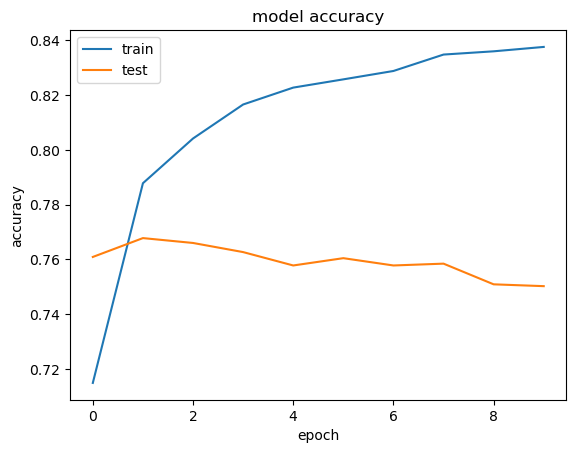

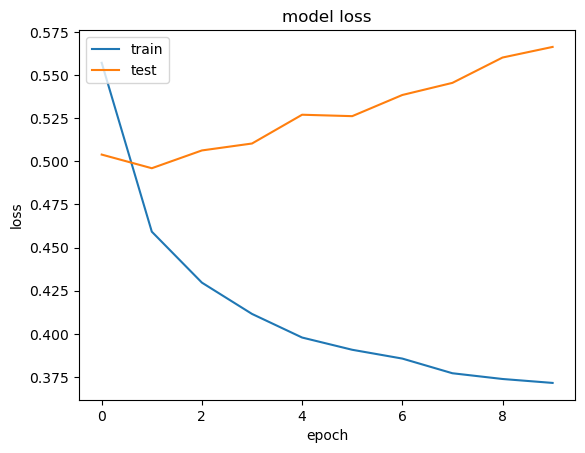

In [37]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [38]:
from keras.layers import Conv1D

In [39]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [40]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8232400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,296,657
Trainable params: 64,257
Non-trainable params: 8,232,400
_________________________________________________________________
None


In [41]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 7s 24ms/step - loss: 0.4692 - acc: 0.7753 - val_loss: 0.3836 - val_acc: 0.8308
Epoch 2/10
282/282 [==============================] - 7s 23ms/step - loss: 0.3418 - acc: 0.8552 - val_loss: 0.3504 - val_acc: 0.8468
Epoch 3/10
282/282 [==============================] - 6s 23ms/step - loss: 0.2885 - acc: 0.8839 - val_loss: 0.3415 - val_acc: 0.8477
Epoch 4/10
282/282 [==============================] - 6s 23ms/step - loss: 0.2453 - acc: 0.9076 - val_loss: 0.3318 - val_acc: 0.8533
Epoch 5/10
282/282 [==============================] - 6s 23ms/step - loss: 0.2037 - acc: 0.9300 - val_loss: 0.3721 - val_acc: 0.8369
Epoch 6/10
282/282 [==============================] - 7s 23ms/step - loss: 0.1719 - acc: 0.9451 - val_loss: 0.3327 - val_acc: 0.8560
Epoch 7/10
282/282 [==============================] - 7s 23ms/step - loss: 0.1398 - acc: 0.9628 - val_loss: 0.3382 - val_acc: 0.8551
Epoch 8/10
282/282 [==============================] - 7s 24ms/step - 

In [42]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 1s 4ms/step - loss: 0.3709 - acc: 0.8526


In [43]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37094664573669434
Test Accuracy: 0.8525999784469604


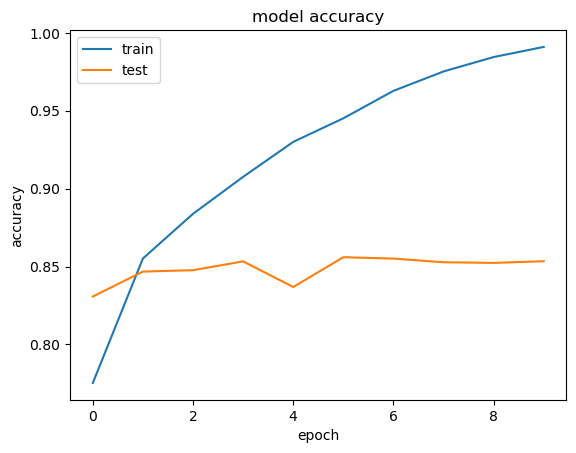

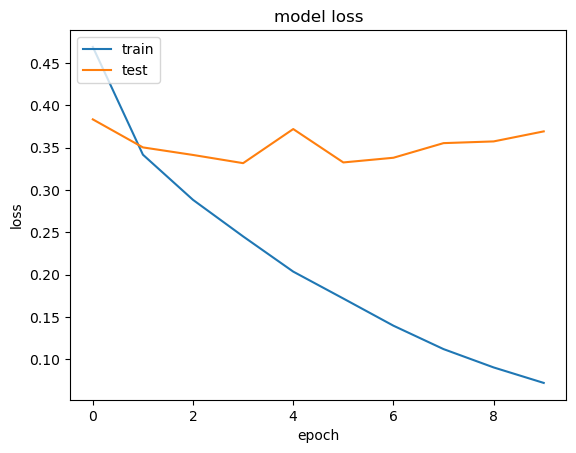

In [44]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [45]:
from keras.layers import LSTM

In [46]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [47]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          8232400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,349,777
Trainable params: 117,377
Non-trainable params: 8,232,400
_________________________________________________________________
None


In [48]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 33s 111ms/step - loss: 0.5313 - acc: 0.7361 - val_loss: 0.4507 - val_acc: 0.7987
Epoch 2/10
282/282 [==============================] - 32s 114ms/step - loss: 0.4289 - acc: 0.8066 - val_loss: 0.3901 - val_acc: 0.8239
Epoch 3/10
282/282 [==============================] - 31s 109ms/step - loss: 0.3797 - acc: 0.8331 - val_loss: 0.3721 - val_acc: 0.8383
Epoch 4/10
282/282 [==============================] - 34s 121ms/step - loss: 0.3496 - acc: 0.8508 - val_loss: 0.3479 - val_acc: 0.8416
Epoch 5/10
282/282 [==============================] - 31s 109ms/step - loss: 0.3321 - acc: 0.8577 - val_loss: 0.3880 - val_acc: 0.8468
Epoch 6/10
282/282 [==============================] - 32s 115ms/step - loss: 0.3107 - acc: 0.8708 - val_loss: 0.3327 - val_acc: 0.8577
Epoch 7/10
282/282 [==============================] - 31s 109ms/step - loss: 0.2967 - acc: 0.8758 - val_loss: 0.3430 - val_acc: 0.8511
Epoch 8/10
282/282 [==============================] - 3

In [49]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 4s 23ms/step - loss: 0.3502 - acc: 0.8572


In [50]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3502058982849121
Test Accuracy: 0.857200026512146


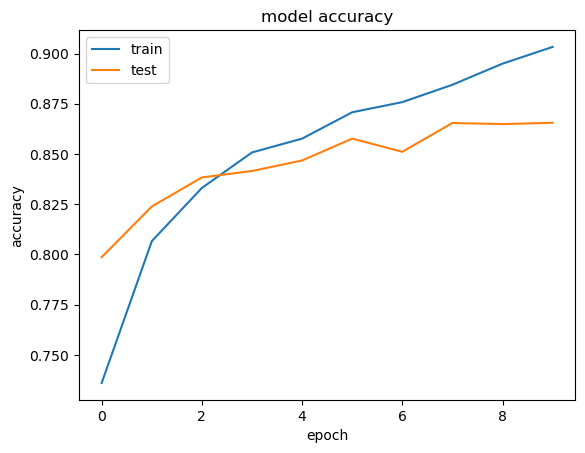

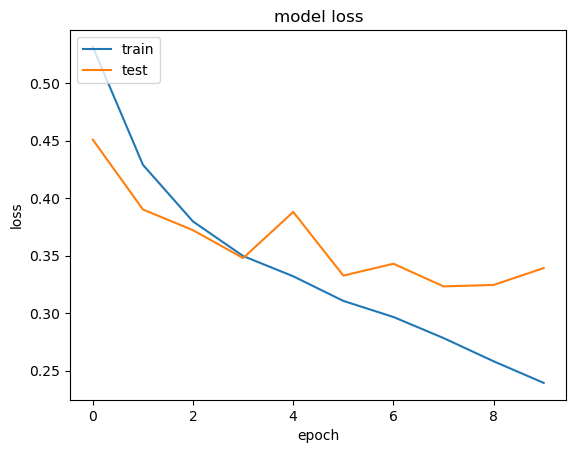

In [51]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [52]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [53]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

Unnamed: 0       Movie                                        Review Text  \
0           0  Ex Machina  Intelligent Movie.\nThis movie is obviously al...   
1           1  Ex Machina  Extraordinary and thought-provoking.\n'Ex mach...   
2           2  Ex Machina  Poor story, only reasonable otherwise.\nIf I h...   
3           3  Ex Machina  Had Great Potential.\nThis movie is one of the...   
4           4    Eternals  Amazing visuals and philosophical concepts!\n\...   
5           5    Eternals  Worst MCU film ever\n\nFollowing the events of...   

   IMDb Rating  
0            9  
1           10  
2            3  
3            1  
4           10  
5            3

In [54]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [55]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [56]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [57]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 710ms/step


array([[0.9568973 ],
       [0.999403  ],
       [0.12336454],
       [0.12251211],
       [0.9626399 ],
       [0.00404677]], dtype=float32)

In [58]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

Movie                                        Review Text  IMDb Rating  \
0  Ex Machina  Intelligent Movie.\nThis movie is obviously al...            9   
1  Ex Machina  Extraordinary and thought-provoking.\n'Ex mach...           10   
2  Ex Machina  Poor story, only reasonable otherwise.\nIf I h...            3   
3  Ex Machina  Had Great Potential.\nThis movie is one of the...            1   
4    Eternals  Amazing visuals and philosophical concepts!\n\...           10   
5    Eternals  Worst MCU film ever\n\nFollowing the events of...            3   

   Predicted Sentiments  
0                   9.6  
1                  10.0  
2                   1.2  
3                   1.2  
4                   9.6  
5                   0.0